# 노말데이터로 학습 진행 
# 모델 : EfficientNetB7

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import numpy as np

import pandas as pd
import cv2
import os
import math
import scipy as sp
import PIL

# Tensorflow
from tensorflow.keras import models, layers, Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, ZeroPadding2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB4, EfficientNetB6, ResNet50V2
#from keras_tuner.tuners import RandomSearch

import scikitplot as skplt
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [ ]:
cd '/content/drive/MyDrive/Colab Notebooks/CV_project/ZCASD_csv_applicate'

/content/drive/MyDrive/Colab Notebooks/CV_project/ZCASD_csv_applicate


In [ ]:
!unzip -qq "/content/drive/MyDrive/Colab Notebooks/CV_project/ZCASD_csv_applicate.zip"

In [ ]:
# batch_size: 한번에 forward & Backword 하는 샘플의 수
batch_size = 5

# Training 수
epochs = 40

# Weight 조절 parameter
LearningRate = 1e-3 # 0.001
Decay = 1e-6

img_width = 224
img_height = 224

In [ ]:
# 디렉토리 경로 설정 필요
CurrentDirectory = "/content/drive/MyDrive/Colab Notebooks/CV_project/ZCASD/"

train_directory = CurrentDirectory + 'Train/'
test_directory  = CurrentDirectory + 'Test/'
# model_directory = CurrentDirectory + 'Model/'
# tensorboard_directory = CurrentDirectory + 'Tensorboard'

In [ ]:
# 모델 Return
model = tf.keras.applications.EfficientNetB7(include_top=False,
    weights='imagenet', input_tensor=None, input_shape=(img_width,img_height,3), pooling=None)
# 마지막 prediction layer를 위한 작업

x = GlobalAveragePooling2D()(model.output)
predictions = Dense(2, activation='softmax')(x)
# predictions = Dense(2, activation='sigmoid')(x)

# Input ~ Output 연결해주기
DeepLearning = Model(inputs=model.input, outputs=predictions)

# learning parameter를 더하여 최종 model compile
DeepLearning.compile(optimizer=
        tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=Decay, amsgrad=False), 
        loss='categorical_crossentropy',
        metrics=['acc'])
    

258088960/258076736 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    featurewise_center=True,
    featurewise_std_normalization=True,
    data_format="channels_last",
    validation_split=0.20) # Train / Validation

# Online-augmentation 비적용 Generator (Test용)
datagen_test = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    data_format="channels_last")




# Generator의 instance 생성 (Train)
train_generator = datagen_train.flow_from_directory(
    train_directory,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode= "categorical",
    subset = "training")

valid_generator = datagen_train.flow_from_directory(
    train_directory,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode= "categorical",
    subset = "validation")

# Generator의 instance 생성 (Test)
test_generator = datagen_test.flow_from_directory(
    test_directory,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    shuffle = False,
    class_mode= "categorical")

Found 7160 images belonging to 2 classes.
Found 1788 images belonging to 2 classes.
Found 2237 images belonging to 2 classes.


In [ ]:
# Call-back 함수

# CheckPoint: Epoch 마다 validation 성능을 검증하여, best performance 일 경우 저장
CP = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/CV_project/Model/0803_B7_1/{epoch:03d}-{loss:.4f}-{acc:.4f}-{val_loss:.4f}-{val_acc:.4f}.hdf5',
            monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# tensorboard
TB = TensorBoard(log_dir='logs', write_graph=True, write_images=True)

# Learning Rate 줄여나가기
LR = ReduceLROnPlateau(monitor='val_loss',factor=0.8,patience=3, verbose=1, min_lr=1e-8)

CALLBACK = [CP, TB, LR]

In [ ]:
######### Training Start
with tf.device("/gpu:0"):
    DeepLearning.fit(train_generator, 
                    epochs=epochs, 
                    callbacks=CALLBACK,
                    shuffle=True, 
                    validation_data=valid_generator)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/40
1432/1432 [==============================] - ETA: 0s - loss: 0.4607 - acc: 0.8130
Epoch 1: val_acc improved from -inf to 0.81879, saving model to /content/drive/MyDrive/Colab Notebooks/CV_project/Model/0803_B7_1/001-0.4607-0.8130-0.5530-0.8188.hdf5
1432/1432 [==============================] - 2136s 1s/step - loss: 0.4607 - acc: 0.8130 - val_loss: 0.5530 - val_acc: 0.8188 - lr: 0.0010
Epoch 2/40
1432/1432 [==============================] - ETA: 0s - loss: 0.4039 - acc: 0.8286
Epoch 2: val_acc improved from 0.81879 to 0.81935, saving model to /content/drive/MyDrive/Colab Notebooks/CV_project/Model/0803_B7_1/002-0.4039-0.8286-0.5232-0.8194.hdf5
1432/1432 [==============================] - 565s 395ms/step - loss: 0.4039 - acc: 0.8286 - val_loss: 0.5232 - val_acc: 0.8194 - lr: 0.0010
Epoch 3/40
1432/1432 [==============================] - ETA: 0s - loss: 0.3845 - acc: 0.8381
Epoch 3: val_acc did not improve from 0.81935
1432/1432 [==============================] - 560s 391ms/step

In [ ]:
train_path = '/content/drive/MyDrive/Colab Notebooks/CV_project/Model/0802_B5_2/006-0.3090-0.8742-0.3629-0.8540.hdf5'
DeepLearning.load_weights(train_path)

# 모델을 평가합니다
loss, acc = DeepLearning.evaluate(test_generator, verbose=2)
print("훈련되지 않은 모델의 정확도: {:5.2f}%".format(100*acc))

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


280/280 - 552s - loss: 0.3382 - acc: 0.8659 - 552s/epoch - 2s/step
훈련되지 않은 모델의 정확도: 86.59%


In [ ]:
Test_prediction = DeepLearning.predict_generator(test_generator, verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


280/280 [==============================] - 19s 59ms/step


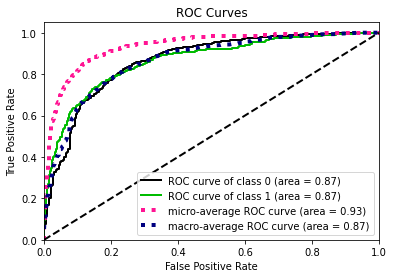

In [ ]:
Result = pd.DataFrame(Test_prediction)
skplt.metrics.plot_roc(test_generator.classes.tolist(), Result)

In [ ]:
GENERATOR = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    data_format="channels_last")

DATA_GENERATOR = GENERATOR.flow_from_directory(
    test_directory,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    shuffle = False,
    classes=["Benign", "Cancer"],
    class_mode= "categorical")

Found 2237 images belonging to 2 classes.


In [ ]:
DeepLearning.summary()

In [ ]:
def grad_cam(model, img, layer_name="top_conv", label_name=None, category_id=None):
    img_tensor = np.expand_dims(img, axis=0)
    conv_layer = model.get_layer(layer_name)
    heatmap_model = tf.keras.Model(inputs=[model.inputs], outputs=[conv_layer.output, model.output])

    with tf.GradientTape() as gtape:
        conv_output, predictions = heatmap_model(img_tensor)
        if category_id == None:
            category_id = np.argmax(predictions[0])
        if label_name:
            print(label_name[category_id])
        output = predictions[:, category_id]
        grads = gtape.gradient(output, conv_output)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat
    return np.squeeze(heatmap), predictions

def grad_camAll(model, img, layer_name="top_conv", blockSize=7, label_name=None, category_id=None):
    img_tensor = np.expand_dims(img, axis=0)
    conv_layer = model.get_layer(layer_name)
    heatmap_model = Model([model.inputs], [conv_layer.output, model.output])

    with tf.GradientTape() as gtape:
        conv_output, predictions = heatmap_model(img_tensor)
        if category_id == None:
            category_id = np.argmax(predictions[0])
        if label_name:
            print(label_name[category_id])
        output = predictions[:, category_id]
        grads = gtape.gradient(output, conv_output)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    res = sp.ndimage.zoom(conv_output[0], (224/blockSize, 224/blockSize, 1), order=2)   
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, res), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat
    return np.squeeze(heatmap)

def show_imgwithheat(img_path, heatmap, alpha=0.4, return_array=False):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = (heatmap*255).astype("uint8")
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype("uint8")
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    imgwithheat = PIL.Image.fromarray(superimposed_img)  
    display(imgwithheat)

    if return_array:
        return superimposed_img

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


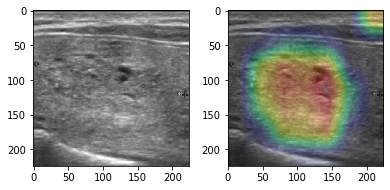

tf.Tensor([[0.98431003 0.01568994]], shape=(1, 2), dtype=float32)
0.984
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [ ]:
Iterator = 27

# item 받아오기
Image, Label = DATA_GENERATOR.__getitem__(Iterator)
Image = Image[0]
# print(Label)


# grad_cam을 활용하여 heatmap 가져오기
HEATMAP1, pred1 = grad_cam(model = DeepLearning, img = Image, layer_name = "top_conv", category_id=0)
heatmap_resize = cv2.resize(HEATMAP1, (224, 224))
heatmap_resize_255 = (heatmap_resize*255).astype("uint8")
heatmap1 = cv2.applyColorMap(255-heatmap_resize_255, cv2.COLORMAP_JET ) / 255
heatmap1[:, :, 2] -= .5
heatmap1[(heatmap1[:, :, 2] < 0), 2] = 0

fig, ax = plt.subplots( nrows=3, ncols=1 )  # create figure & 1 axis
fig.set_size_inches(9.0, 3.0)
ax = plt.subplot(1,3,1)
ax.imshow(Image)
ax = plt.subplot(1,3,2)
ax.imshow(Image)
ax.imshow(heatmap1, cmap=plt.cm.jet, alpha=0.3, interpolation='nearest' )
# ax = plt.subplot(1,3,3)
# ax.imshow(Image)
# ax.imshow(heatmap1, cmap=plt.cm.jet, alpha=0.3, interpolation='nearest' )

plt.subplots_adjust(left = 0.06, wspace = 0.25, hspace = 0.1, bottom = 0.025, top = 0.975)
pred=round(pred1.numpy()[0][0],3)
plt.show()

print(pred1)
print(pred)
print(Label)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


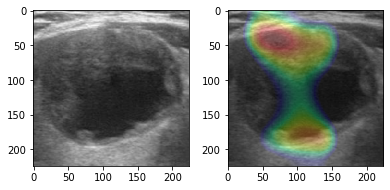

tf.Tensor([[0.98431003 0.01568994]], shape=(1, 2), dtype=float32)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [ ]:
Iterator = 31

# item 받아오기
Image, Label = DATA_GENERATOR.__getitem__(Iterator)
Image = Image[0]
# print(Label)


# grad_cam을 활용하여 heatmap 가져오기
HEATMAP1 = grad_camAll(model = DeepLearning, img = Image, layer_name = "top_conv", category_id=0)
heatmap_resize = cv2.resize(HEATMAP1, (224, 224))
heatmap_resize_255 = (heatmap_resize*255).astype("uint8")
heatmap1 = cv2.applyColorMap(255-heatmap_resize_255, cv2.COLORMAP_JET ) / 255
heatmap1[:, :, 2] -= .5
heatmap1[(heatmap1[:, :, 2] < 0), 2] = 0

fig, ax = plt.subplots( nrows=3, ncols=1 )  # create figure & 1 axis
fig.set_size_inches(9.0, 3.0)
ax = plt.subplot(1,3,1)
ax.imshow(Image)
ax = plt.subplot(1,3,2)
ax.imshow(Image)
ax.imshow(heatmap1, cmap=plt.cm.jet, alpha=0.3, interpolation='nearest' )
# ax = plt.subplot(1,3,3)
# ax.imshow(Image)
# ax.imshow(heatmap1, cmap=plt.cm.jet, alpha=0.3, interpolation='nearest' )

plt.subplots_adjust(left = 0.06, wspace = 0.25, hspace = 0.1, bottom = 0.025, top = 0.975)
# pred=round(pred1.numpy()[0][0],3)
plt.show()

print(pred1)
# print(pred)
print(Label)